In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os 

import cmocean

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir']= os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

from ll_Balltree import *
%run -i 'll_Balltree.py'

from matplotlib import pyplot as plt, colors

from glob import glob
from os import path

In [2]:
outputDir = 'data/posterior_computation_data/'
gom_masks = xr.open_dataset(outputDir + 'domain_cell_masks_w_regions.nc')

In [3]:
# GLOBAL CONSTANTS
MIN_LON = np.min(gom_masks['lon'].values)
MAX_LON = np.max(gom_masks['lon'].values)
MIN_LAT = np.min(gom_masks['lat'].values)
MAX_LAT = np.max(gom_masks['lat'].values)

#domain width and height (cell counts)
LAT_SIZE = gom_masks.dims['lat']
LON_SIZE = gom_masks.dims['lon']

#cell size
D_LON = gom_masks["lon"][1].values - gom_masks["lon"][0].values
D_LAT = gom_masks["lat"][1].values - gom_masks["lat"][0].values

BIN_CELL_LATS = gom_masks.bin_cell_lats.values
BIN_CELL_LONS = gom_masks.bin_cell_lons.values

MIN_LON, MAX_LON, MIN_LAT, MAX_LAT,LAT_SIZE,LON_SIZE, D_LON,D_LAT

(-97.98001098632812,
 -76.45999145507812,
 18.140000343322754,
 31.899998664855957,
 345,
 539,
 0.03997802734375,
 0.03999900817871094)

In [4]:
# CREATE COAST CELL TREE
idx_coast_mask = np.where(gom_masks.coastalmask == 1)
coast_cells = get_cells(idx_mask = idx_coast_mask, 
                            lats = gom_masks['lat'].values,
                            lons = gom_masks['lon'].values)
coast_cell_tree = build_ll_BallTree(coast_cells)

In [5]:
rawInputDir = 'data/raw_input/'

River Prior (Not Scaled)

In [6]:
# PROCESS RIVER DATA
def preprocess_river_data(file_loc):
    rivers = pd.read_csv(file_loc).dropna(subset = 'i_mid')
    rivers = rivers[(rivers['X'] >= MIN_LON) & (rivers['X'] <= MAX_LON) & (rivers['Y'] >= MIN_LAT) & (rivers['Y'] <= MAX_LAT)]
    rivers['i_mid_kg']  = (rivers['i_mid'] * 1000)
    rivers['i_mid_kg_mon'] = rivers['i_mid_kg'] / 12
    rivers_considered = rivers[rivers['i_mid_kg_mon'] > 0.0]
    return rivers_considered

file_loc = rawInputDir + 'PlasticRiverInputs.csv'
rivers_considered = preprocess_river_data(file_loc)
total_mon_river_input = np.sum(rivers_considered.i_mid_kg_mon)

# FIND CLOSEST CELL TO RIVER LOCATIONS
river_cells = get_cells(idx_mask = None, lats = rivers_considered.Y.values, lons = rivers_considered.X.values)
_, river_ind = query_ll_BallTree(tree = coast_cell_tree, cells = river_cells)

# ADD RIVER INPUT TO COSTAL CELL DATAFRAME
d = {'river_ind': river_ind, 'river_kg': rivers_considered['i_mid_kg'].values}

df_all_rivers = pd.DataFrame(data=d)
counts_rivers  = df_all_rivers.river_ind.value_counts(sort = False)
df_all_rivers = df_all_rivers.groupby('river_ind').sum()

df_all_rivers

# ADD RIVER INPUT TO NETCDF
final_river_inds = df_all_rivers.index.values
final_river_kg = df_all_rivers['river_kg'].values

river_input = np.zeros((LAT_SIZE, LON_SIZE))
idx_river_lats = idx_coast_mask[0][final_river_inds]
idx_river_lons = idx_coast_mask[1][final_river_inds]
river_input[idx_river_lats, idx_river_lons] = final_river_kg
assert(int(np.nansum(river_input)) == int(np.sum(rivers_considered['i_mid_kg'].values))) # check the total river kg count
river_input_mon = river_input / 12.0

/home/dpojunas/.conda/envs/py3_parcels/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


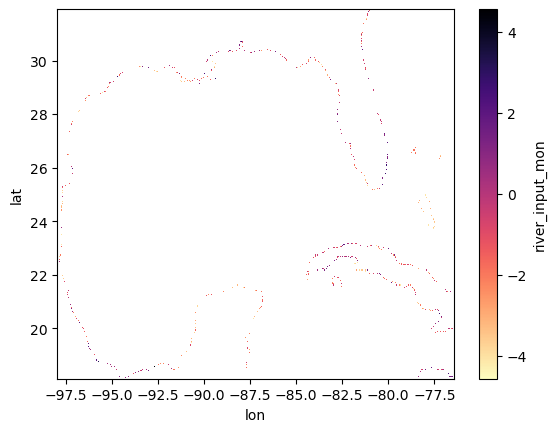

In [7]:
gom_masks = gom_masks.assign(river_input_mon = (('lat', 'lon'), river_input_mon))
np.log10((gom_masks.river_input_mon)).plot(cmap='magma_r')

Land Prior (Not Scaled)

In [8]:
# PREPROCESS LAND DATA
mpw_ds = xr.open_zarr(rawInputDir + 'mpw_output')
mpw_ds = mpw_ds.rename({'X': 'lon','Y': 'lat'})
mpw_ds = mpw_ds.isel(lat=slice(None, None, -1))

# FIND CLOSEST CELL TO LAND LOCATIONS
land_cells_idx = np.where(mpw_ds.mpw_output >= 1.0)
land_cells = get_cells(idx_mask = land_cells_idx, 
                            lats = mpw_ds.lat.values,
                            lons = mpw_ds.lon.values)

land_mpw = mpw_ds.mpw_output.values[land_cells_idx]
land_dist, land_ind = query_ll_BallTree(tree = coast_cell_tree, cells = land_cells)

# FIND ALL LOCATIONS WITHIN 50km OF THE COAST
land_dist_to_coast = 50.0
land_cells_within_radius = np.where(land_dist <= land_dist_to_coast)[0]
coastal_ind_within_radius = land_ind[land_cells_within_radius]
land_mpw_to_coast = land_mpw[land_cells_within_radius]

# ADD LAND INPUT TO COASTAL CELL DATAFRAME
df_all_land = pd.DataFrame(data={'coastal_ind_within_radius': coastal_ind_within_radius, 'land_mpw_to_coast': land_mpw_to_coast})
counts_land  = df_all_land.coastal_ind_within_radius.value_counts(sort = False)
df_all_land = df_all_land.groupby('coastal_ind_within_radius').sum()

# ADD LAND INPUT TO NETCDF
final_land_inds = df_all_land.index.values
final_land_kg = df_all_land['land_mpw_to_coast'].values

land_input = np.zeros((LAT_SIZE, LON_SIZE))
idx_land_lats = idx_coast_mask[0][final_land_inds]
idx_land_lons =  idx_coast_mask[1][final_land_inds]
land_input[idx_land_lats, idx_land_lons] = final_land_kg
assert(int(math.ceil(np.nansum(land_input))) == int(math.ceil(np.sum(land_mpw_to_coast)))) # sanity check

# only 15% of land inputs make it to the ocean
land_input_mon = land_input * 0.15 / 12.0

/home/dpojunas/.conda/envs/py3_parcels/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


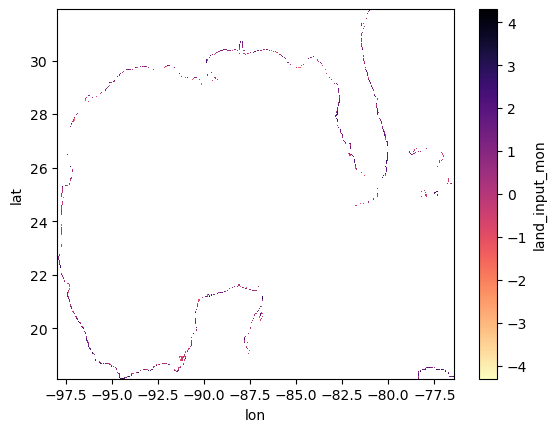

In [9]:
gom_masks = gom_masks.assign(land_input_mon = (('lat', 'lon'), land_input_mon))
np.log10((gom_masks.land_input_mon)).plot(cmap = 'magma_r')

Fishing Prior

In [10]:
inputDir = (rawInputDir +'fishing_data/')
input_files = sorted(glob(inputDir + '*.csv' ))

y_2019 = pd.to_datetime(np.arange('2019-01', '2020-01', dtype='datetime64[M]'))
y_2020 = pd.to_datetime(np.arange('2020-01', '2021-01', dtype='datetime64[M]'))
y_2021 = pd.to_datetime(np.arange('2021-01', '2022-01', dtype='datetime64[M]'))
f_meta = {1: (input_files[0], y_2019), 
          2: (input_files[1], y_2020), 
          3: (input_files[2], y_2021), 
         }

time = pd.to_datetime(np.arange('2019-01', '2022-01', dtype='datetime64[M]'))
time_idx = [i for i in range(3*12)]
time_dict = dict(zip(time, time_idx))

def fetch_fishing_data(fname):
    fishing = pd.read_csv(fname)
    fishing['time'] = pd.to_datetime(fishing['Time Range'])
    fishing = fishing[(fishing['Lat'] >= MIN_LAT) & (fishing['Lat'] <= MAX_LAT) & (fishing['Lon'] >= MIN_LON) & (fishing['Lon'] <= MAX_LON)]
    return fishing

source_windows = pd.to_datetime(np.arange('2019-01', '2022-01', dtype='datetime64[M]')).astype('datetime64[ns]')

fishing_activity = np.zeros((len(source_windows), LAT_SIZE, LON_SIZE))

for i in range(1, 4):
    meta = f_meta[i]
    filename = meta[0]
    date_range = meta[1]
    
    fishing_df = fetch_fishing_data(filename)
    fishing_df
    for date in date_range:
        time_idx = time_dict[date]
        vals = fishing_df[(fishing_df.time.dt.year == date.year) & (fishing_df.time.dt.month == date.month)]
        fishing_activity_mon = np.histogram2d(vals.Lon, vals.Lat, weights = vals['Apparent Fishing Hours'], bins=(BIN_CELL_LONS, BIN_CELL_LATS))[0].T
        
        fishing_activity[time_idx, :, :] = fishing_activity_mon

In [15]:
# Calculate Fishing Kg Proportion
###

#############
land_input = np.tile(land_input_mon, (len(source_windows),1,1))
river_input = np.tile(river_input_mon, (len(source_windows),1,1))
#############

# Global Prior Proportions given by Leberton
n_l, n_r, n_f = 66.6/100, 13.4/100, 20/100

# Used to assign microplastic over the entire spatiotemporal domain
# (land+river_counts) / (total_counts) = (land+river proportion)
total_land_input = np.sum(land_input)
total_river_input = np.sum(river_input)
total_land_river_input = (total_land_input + total_river_input)
total_input =  total_land_river_input / (n_l + n_r)
total_fishing_input = total_input- total_land_river_input

prior_input_total_prop = np.array([total_land_input, total_river_input, total_fishing_input]) / total_input
print('Proportions | Land', 100*prior_input_total_prop[0], ' | River', 100*prior_input_total_prop[1], '| Fishing ', 100*prior_input_total_prop[2])

#############
fishing_input = total_fishing_input * (fishing_activity / np.sum(fishing_activity))
#############

assert(int(total_fishing_input) == int(np.sum(fishing_input)))


Proportions | Land 51.9995088682946  | River 28.000491131705395 | Fishing  20.00000000000001


In [13]:
# Build masks Data
prior_mpw = xr.Dataset(
    {
        'land_input': (['time', 'lat', 'lon' ], land_input),
        'river_input': (['time', 'lat', 'lon' ], river_input),
        'fishing_input': (['time', 'lat', 'lon' ], fishing_input),
    },
    coords={
        'time': source_windows,
        'lat': gom_masks['lat'].values,
        'lon': gom_masks['lon'].values,
    },
)

In [16]:
prior_denom = np.sum(land_input + river_input + fishing_input)

l_prior = land_input / prior_denom
r_prior = river_input / prior_denom
f_prior = fishing_input / prior_denom

# sanity check
assert(round(np.sum(l_prior), 4) == round(prior_input_total_prop[0], 4))
assert(round(np.sum(r_prior), 4) == round(prior_input_total_prop[1], 4))
assert(round(np.sum(f_prior), 4) == round(prior_input_total_prop[2], 4))
assert(int(np.sum(l_prior + r_prior + f_prior)) == 1)

In [13]:
# Build masks Data
prior = xr.Dataset(
    {
        'l_prior': (['time', 'lat', 'lon' ], l_prior),
        'r_prior': (['time', 'lat', 'lon' ], r_prior),
        'f_prior': (['time', 'lat', 'lon' ], f_prior),
    },
    coords={
        'time': source_windows,
        'lat': gom_masks['lat'].values,
        'lon': gom_masks['lon'].values,
    },
)

/home/dpojunas/.conda/envs/py3_parcels/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


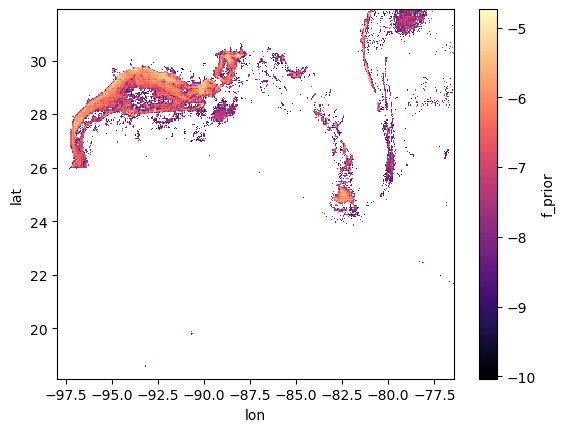

In [14]:
np.log10(prior.f_prior.mean(dim ='time')).plot(cmap='magma')

Coastal Extension for Plotting

In [15]:
# FIND CLOSEST CELL TO LAND LOCATIONS
landmask_cells_idx = np.where((gom_masks.coastalmask + gom_masks.landmask) == 1.0)
landmask_cells = get_cells(idx_mask = landmask_cells_idx, 
                            lats = gom_masks['lat'].values,
                            lons = gom_masks['lon'].values)

landmask_dist, landmask_ind = query_ll_BallTree(tree = coast_cell_tree, cells = landmask_cells)

# FIND ALL LOCATIONS WITHIN 50km OF THE COAST FOR PLOTTING COASTAL REGIONS
landmask_dist_to_coast = 40.0
landmask_cells_within_r = np.where(landmask_dist < landmask_dist_to_coast)[0]
land_within_r_lat = landmask_cells_idx[0][landmask_cells_within_r]
land_within_r_lon = landmask_cells_idx[1][landmask_cells_within_r]

coast_idx_within_r = np.full( (LAT_SIZE, LON_SIZE),  np.nan)
coast_idx_within_r[land_within_r_lat, land_within_r_lon] = landmask_ind[landmask_cells_within_r]

gom_masks = gom_masks.assign(plotcoastidx = (('lat', 'lon'), coast_idx_within_r))

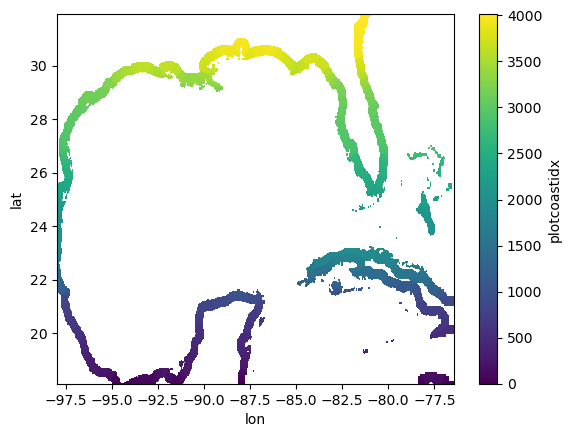

In [16]:
gom_masks.plotcoastidx.plot()

In [17]:
gom_masks.to_netcdf(outputDir + 'gom_masks.nc')
prior.to_netcdf(outputDir + 'prior.nc')
prior_mpw.to_netcdf(outputDir + 'prior_mpw.nc')